In [1]:
import pandas as pd

In [2]:
# -----------------------------
# 1. Load and prepare data
# -----------------------------

# Load base dataset
df_path = "../data/clean_data.csv"
df = pd.read_csv(df_path).drop(["Unnamed: 0"], axis=1)

# Sort for consistent year ordering within each country
df = df.sort_values(["alpha_2", "year"]).copy()

In [5]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Average across years per country
X = (
    df[['name', 'life_expectancy', 'urban_population_pct', 
        'internet_users_pct', 'human_capital_index']]
    .groupby('name').mean()
    .dropna()
)

# Scale features to mean=0, std=1 (important for K-means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [6]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to your dataframe
X['cluster'] = labels


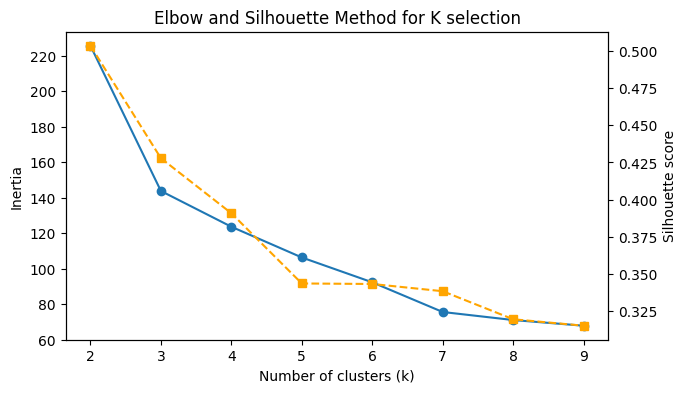

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

inertias = []
silhouettes = []

K_range = range(2, 10)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42).fit(X_scaled)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_scaled, km.labels_))

fig, ax1 = plt.subplots(figsize=(7,4))
ax2 = ax1.twinx()
ax1.plot(K_range, inertias, 'o-', label='Inertia')
ax2.plot(K_range, silhouettes, 's--', color='orange', label='Silhouette')
ax1.set_xlabel('Number of clusters (k)')
ax1.set_ylabel('Inertia')
ax2.set_ylabel('Silhouette score')
plt.title('Elbow and Silhouette Method for K selection')
plt.show()


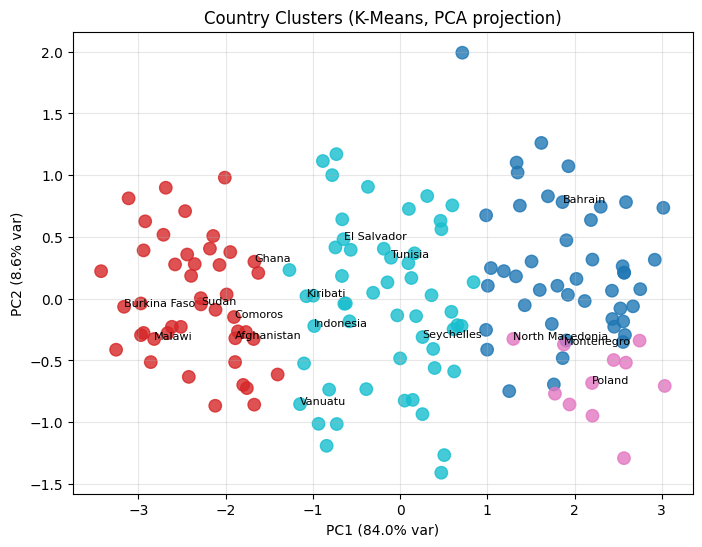

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_coords = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(pca_coords[:,0], pca_coords[:,1], 
            c=labels, cmap='tab10', s=80, alpha=0.8)
plt.title('Country Clusters (K-Means, PCA projection)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)')

# Optionally annotate a few countries
for i, country in enumerate(X.index):
    if i % 10 == 0:  # label every 10th to reduce clutter
        plt.text(pca_coords[i,0], pca_coords[i,1], country, fontsize=8)
plt.grid(True, alpha=0.3)
plt.show()


In [11]:
cluster_summary = X.groupby('cluster').mean().round(2)
print(cluster_summary)


         life_expectancy  urban_population_pct  internet_users_pct  \
cluster                                                              
0                  74.45                 77.38               28.04   
1                  54.03                 25.54                4.90   
2                  74.59                 61.62               44.79   
3                  66.79                 48.28               15.24   

         human_capital_index  
cluster                       
0                       0.69  
1                       0.39  
2                       0.69  
3                       0.54  


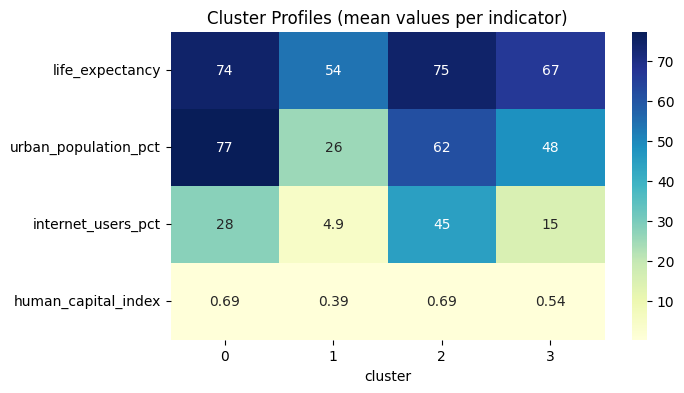

In [13]:
import seaborn as sns

plt.figure(figsize=(7,4))
sns.heatmap(cluster_summary.T, cmap="YlGnBu", annot=True)
plt.title("Cluster Profiles (mean values per indicator)")
plt.show()
